In [68]:
import numpy as np
import scipy
import scipy.signal
from wipy.wipy_utils import utils
from wipy.preprocess import filter
from wipy.preprocess import normalize
from wipy.preprocess import mute
import obspy
import matplotlib
from matplotlib import pyplot as plt


In [69]:
# obs_data_path = 
# obs_data_path = "Field-Data/Acceleration-Data-SU/000000/Uz_file_single_d.su"
obs_data_path = "Field-Data/Displacement-Data/000000/Uz_file_single_d.su"
obs = obspy.read(obs_data_path, format="SU")

# test_data_path = "init_data/000000/Ux_file_single_d.su"
test_data_path = "test_data/000000/Uz_file_single_d.su"
# test_data_path = "Field-Data/Displacement-Data/000000/Uz_file_single_d.su"
tes = obspy.read(test_data_path, format="SU")

Nr = len(obs)
Nt = len(obs[0].data)
dt = obs.traces[0].stats.delta

freq_min = 10.0
freq_max = 60.0
filt_order = 10
min_offset = 30.0
max_offset = 120.0
t_taper = 0.05

mute_below_func = lambda offset: 0.125 + (0.22/200)*offset
# mute_below_func = lambda offset: 0.125 + (0.05/200)*offset
mute_above_func = lambda offset: 0.075 + (0.05/200)*offset
# mute_above_func = lambda offset: 0.075 + (0.22/200)*offset

### old muting paramerts
# mute_below_func = lambda offset: 0.150 + (0.25/200)*offset
# mute_above_func = lambda offset: 0.025 + (0.10/200)*offset



In [70]:
obs = mute.mute_below_func(obs, mute_below_func, t_taper)
obs = mute.mute_above_func(obs, mute_above_func, t_taper)
obs = mute.mute_far_offsets(obs, max_offset)
obs = mute.mute_short_offsets(obs, min_offset)
# obs = filter.lowpass_filter(obs, freq_max, filt_order)
obs = filter.bandpass_filter(obs, freq_min, freq_max, filt_order)
obs = normalize.trace_normalize(obs)

tes = mute.mute_below_func(tes, mute_below_func, t_taper)
tes = mute.mute_above_func(tes, mute_above_func, t_taper)
tes = mute.mute_far_offsets(tes, max_offset)
tes = mute.mute_short_offsets(tes, min_offset)
# tes = filter.lowpass_filter(tes, freq_max, filt_order)
tes = filter.bandpass_filter(tes, freq_min, freq_max, filt_order)
tes = normalize.trace_normalize(tes)

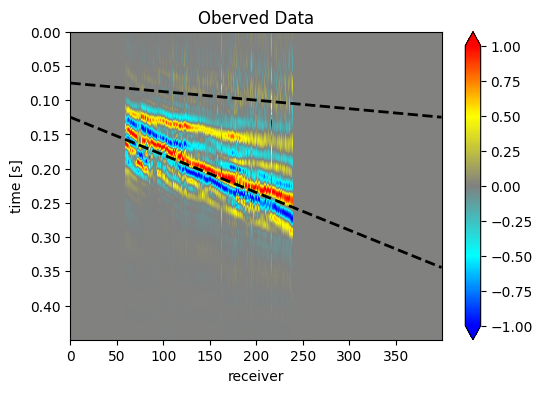

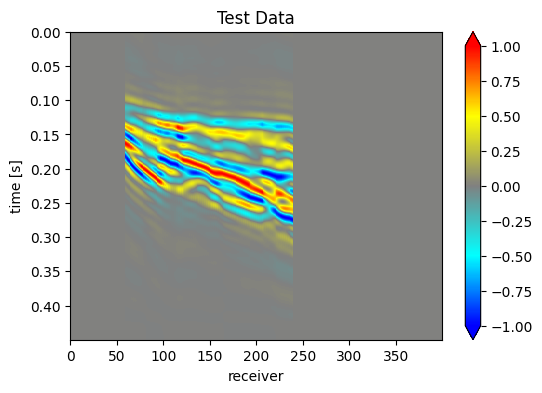

In [71]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", 
    ["blue", "cyan", "gray", "yellow", "red"])

fig1, ax1, = utils.plot_image(obs, 1, cmap=cmap)
ax1.invert_yaxis()
ax1.set_title("Oberved Data")
ax1.plot(np.arange(0,400,1), mute_below_func(np.arange(0,400,1)*0.5), "k--", linewidth=2)
ax1.plot(np.arange(0,400,1), mute_above_func(np.arange(0,400,1)*0.5), "k--", linewidth=2)
plt.show()

fig2, ax2, = utils.plot_image(tes, 1, cmap=cmap)
ax2.invert_yaxis()
ax2.set_title("Test Data")
plt.show()

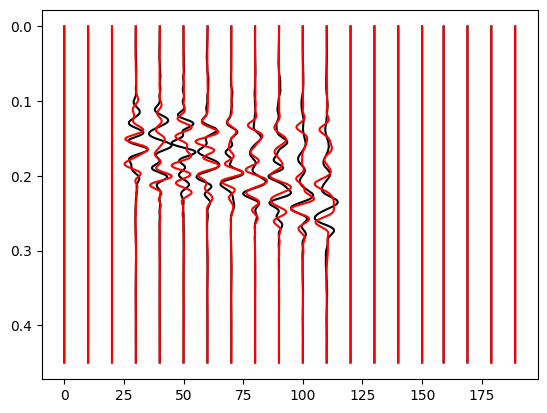

In [73]:
utils.plot_traces(obs, gain=5, deci=20)
utils.plot_traces(tes, gain=5, deci=20, line_spec="r")
plt.gca().invert_yaxis()

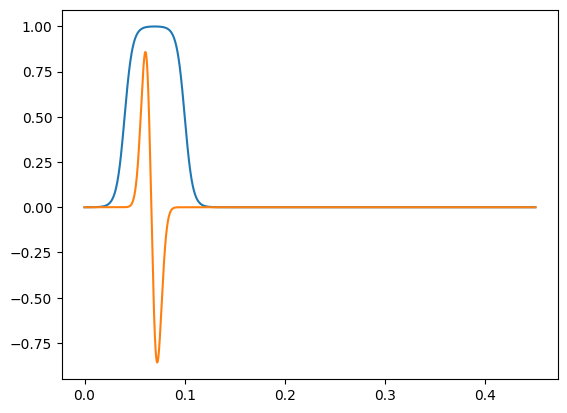

In [87]:
T = np.arange(0, Nt*dt, dt)

# # gaussian stf
# gauss_stf = lambda t, t0, f0: -8 * (t-t0) * f0 * (np.exp(-1 * ((4*f0)**2) * ((t-t0)**2))) 
# f0 = 20.0
# t0 = 1/f0
# ref_stf = gauss_stf(T, t0, f0)
# ref_stf = ref_stf / np.max(np.abs(ref_stf))
ref_stf_path = "specfem2d/DATA/stf_000000.txt"
ref_stf = np.loadtxt(ref_stf_path, delimiter=",")
ref_stf = ref_stf[:,1]
ref_stf_fft = np.fft.rfft(ref_stf)

# sos = scipy.signal.butter(10, freq_max, btype='lowpass', output='sos', fs=1/dt)
# ref_stf = scipy.signal.sosfiltfilt(sos, ref_stf)

# stf_true_path = "specfem2d/DATA/stf_000000.txt"
# stf_true = np.loadtxt(stf_true_path, delimiter=",")
# stf_true = stf_true[:,1]
# stf_true = stf_true / np.max(np.abs(stf_true))

# cleaning double sigmoid function
sigmoid = lambda t, t0, t1, alpha, beta: 1/(1 + np.exp(-(alpha*(t-t0)))) * 1/(1 + np.exp((beta*(t-t1))))

clean = sigmoid(T, 0.04, 0.10, 250, 250)

plt.plot(T, clean)
plt.plot(T, ref_stf)
# plt.plot(T, ref_stf*clean, "--")
# plt.plot(T, stf_true)
# plt.vlines(0.05, 0, 1)
# plt.vlines(0.10, 0, 1)


In [76]:
freqs = scipy.fft.fftfreq(Nt, dt)[:Nt//2]
# plt.plot(freqs)


In [81]:
STF = np.zeros((Nt, Nr))

for i in range(len(obs)):

    if np.sum(np.abs(obs[i].data)) >  0.0:
        obs_fft = scipy.fft.rfft(obs[i].data)
        tes_fft = scipy.fft.rfft(tes[i].data)
        b_fft = np.zeros(len(ref_stf_fft), dtype="complex")
        eps = np.max(np.abs(tes_fft*np.conj(tes_fft))) * 1.0

        for j in range(len(freqs)): 
            freq = freqs[j]
            if freq < freq_max and freq > freq_min:
                numer = (obs_fft[j]*np.conj(tes_fft[j]))
                denom = np.real(tes_fft[j]*np.conj(tes_fft[j])) + eps
                b_fft[j] = (numer/denom)
        
        STF[:,i] = np.fft.irfft(b_fft*ref_stf_fft) * clean

 


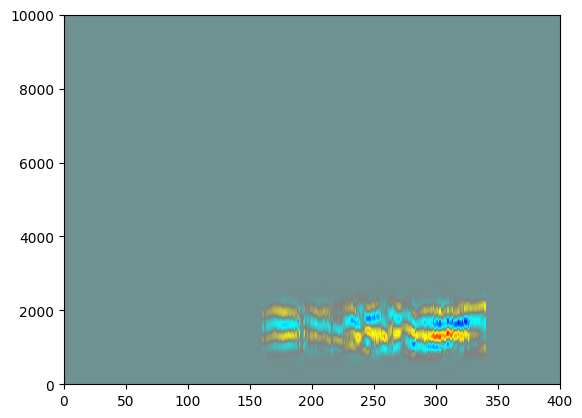

In [82]:
STF[np.isnan(STF)] = 0
plt.pcolormesh(STF, shading="auto", cmap=cmap)

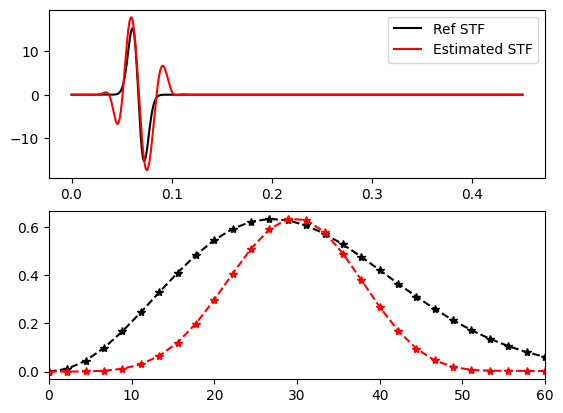

In [83]:
stf = np.sum(STF, axis=1)
# plt.plot(STF_true[:,1]*np.max(np.abs(stf))/np.max(np.abs(STF_true[:,1])), "k", label="True Filtered STF")
plt.subplot(211)
plt.plot(T, ref_stf*np.max(np.abs(stf)), "k", label="Ref STF")
plt.plot(T, stf, "r", label="Estimated STF")
plt.legend()

plt.subplot(212)
f0, p0 = scipy.signal.periodogram(ref_stf, 1/dt, )
f1, p1 = scipy.signal.periodogram(stf, 1/dt, )
plt.plot(f0, p0*np.max(np.abs(p1))/np.max(np.abs(p0)), "k*--")
plt.plot(f1, p1, "r*--")
plt.xlim(0, 60)
plt.show()


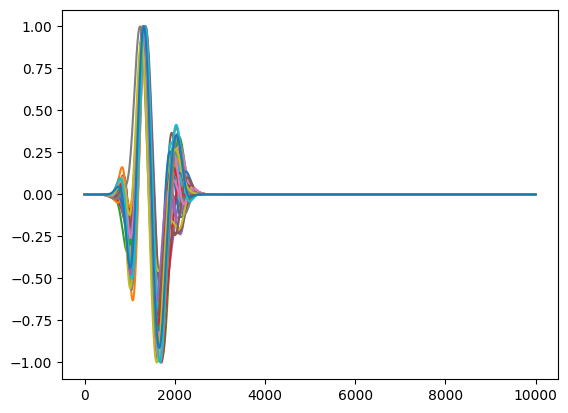

In [85]:
obs_data_folder = "Field-Data/Displacement-Data"
test_data_folder = "test_data"
output_folder = "10-60Hz_stfs"

for shot in range(41):

    stf = np.zeros(Nt)

    for comp in ["x", "z"]:

        # load the data
        gather_names = "U" + comp + "_file_single_d.su"
        
        obs_data_path = obs_data_folder + "/{:06d}/".format(shot) + gather_names
        obs = obspy.read(obs_data_path, format="SU")

        test_data_path = test_data_folder + "/{:06d}/".format(shot) + gather_names
        tes = obspy.read(test_data_path, format="SU")

        # preprocess the data
        obs = mute.mute_below_func(obs, mute_below_func, t_taper)
        obs = mute.mute_above_func(obs, mute_above_func, t_taper)
        obs = mute.mute_far_offsets(obs, max_offset)
        obs = mute.mute_short_offsets(obs, min_offset)
        # obs = filter.lowpass_filter(obs, freq_max, filt_order)
        obs = filter.bandpass_filter(obs, freq_min, freq_max, filt_order)
        obs = normalize.trace_normalize(obs)

        tes = mute.mute_below_func(tes, mute_below_func, t_taper)
        tes = mute.mute_above_func(tes, mute_above_func, t_taper)
        tes = mute.mute_far_offsets(tes, max_offset)
        tes = mute.mute_short_offsets(tes, min_offset)
        # tes = filter.lowpass_filter(tes, freq_max, filt_order)
        tes = filter.bandpass_filter(tes, freq_min, freq_max, filt_order)
        tes = normalize.trace_normalize(tes)

        # load the reference stf
        ref_stf_path = "specfem2d/DATA/stf_{:06d}.txt".format(shot)
        ref_stf = np.loadtxt(ref_stf_path, delimiter=",")
        ref_stf = ref_stf[:,1]
        ref_stf_fft = np.fft.rfft(ref_stf)

        # compute source-time functions
        STF = np.zeros((Nt, Nr))

        for i in range(len(obs)):

            if np.sum(np.abs(obs[i].data)) >  0.0:
                obs_fft = scipy.fft.rfft(obs[i].data)
                tes_fft = scipy.fft.rfft(tes[i].data)
                b_fft = np.zeros(len(ref_stf_fft), dtype="complex")
                eps = np.max(np.abs(tes_fft*np.conj(tes_fft))) * 1.0

                for j in range(len(freqs)): 
                    freq = freqs[j]
                    if freq < freq_max and freq > freq_min:
                        numer = (obs_fft[j]*np.conj(tes_fft[j]))
                        denom = np.real(tes_fft[j]*np.conj(tes_fft[j])) + eps
                        b_fft[j] = (numer/denom)
                
                STF[:,i] = np.fft.irfft(b_fft*ref_stf_fft) * clean

        STF[np.isnan(STF)] = 0.0
        stf += np.sum(STF, axis=1)

    # normalize stf
    stf /= np.max(abs(stf))
    
    # plot stf
    plt.plot(stf, label="Estimated STF")

    # write stf
    output_path = output_folder + "/stf_{:06d}.txt".format(shot)
    np.savetxt(output_path, np.vstack((T, stf)).T, delimiter=",  ")


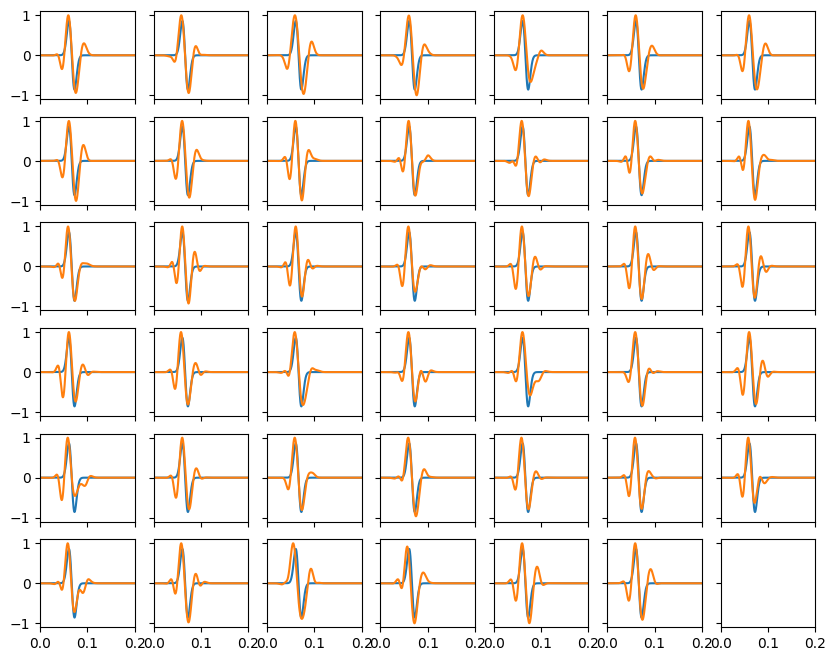

In [84]:
src_path_1 = "specfem2d/DATA"
src_path_2 = "10-60Hz_stfs"

fig, ax = plt.subplots(6, 7, figsize=(10,8), sharex=True, sharey=True)

for i in range(41):

    path1 = src_path_1 + "/stf_{:06d}.txt".format(i)
    path2 = src_path_2 + "/stf_{:06d}.txt".format(i)
    
    stf1 = np.loadtxt(path1, delimiter=",") 
    stf2 = np.loadtxt(path2, delimiter=",") 

    ax.flat[i].plot(stf1[:,0], stf1[:,1])
    ax.flat[i].plot(stf2[:,0], stf2[:,1])
    ax.flat[i].set_xlim(0, 0.2)

In [ ]:
# def make_data_array(data) -> np.array:

#     dat_array = np.zeros(shape=(data.traces[0].stats['npts'], 1))

#     for trace in data.traces:
#         # dat_array = np.c_[dat_array, trace.data/np.max(abs(trace.data))]
#         dat_array = np.c_[dat_array, trace.data]

#     return dat_array

# # dat_array = make_data_array(obs)

# # # plt.pcolormesh(dat_array)
# # plt.show()

# # dat_array = scipy.signal.wiener(dat_array, mysize=(25,25))

# # # plt.pcolormesh(dat_array)
# # plt.show()

# # for indx, trace in enumerate(obs):
# #     trace.data = dat_array[:,indx]